# Influenza Epidemic Data

### Import all the necessary libraries 

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from io import StringIO
%matplotlib inline

###  Data is collected from WHO data repository. The influenzas data can be found on WHO web page

http://apps.who.int/flumart/Default?ReportNo=12.

Data is collected from 1.1.1995 – 1.2.2018. Data can be exported in diffrent format, CSV is selected in this case

In [2]:
data = pd.read_csv(r"..\epidemic\epid_data.csv")

In [88]:
data.tail()

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
73322,Zambia,African Region of WHO,Eastern Africa,2018,5,2018-01-29,2018-04-02,7.0,0.0,NaN,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
73323,Zambia,African Region of WHO,Eastern Africa,2018,6,2018-05-02,2018-11-02,8.0,0.0,NaN,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
73324,Zambia,African Region of WHO,Eastern Africa,2018,7,2018-12-02,2018-02-18,0.0,0.0,NaN,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
73325,Zambia,African Region of WHO,Eastern Africa,2018,8,2018-02-19,2018-02-25,20.0,0.0,NaN,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,Sporadic
73326,Zambia,African Region of WHO,Eastern Africa,2018,9,2018-02-26,2018-04-03,0.0,0.0,NaN,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report


In [93]:
data.shape

(73327, 22)

### Saving some data for testing for modle evaluation latter

In [113]:
test = data.loc[data['Year'] == 2018 & 2017] # put this data for testing (21 weeks of records)

In [115]:
data = data.loc[data['Year'] != 2018 & 2017] # the rest for training

In [114]:
len(test)

6189

In [116]:
len(data)

66408

In [117]:
test.TITLE.unique()# check if it contains all the 6 unique values for the test too

array(['Sporadic', 'No Report', 'Regional Outbreak', 'Widespread Outbreak',
       'Local Outbreak', 'No Activity'], dtype=object)

### Data preparation

The attributes can be catagorized as
    1. Regions
    2. Duration of spread
    3. Types of influenzas and 
    4. categories of the spread based of ILI (Influenza like illness) report
For simplicity country:  is selected for region
               SDATE and EDATE : for the duration of the spread
               INF_A(Influenza A), INF_B(Influenza B), ALL_INF(Total Influenza positive viruses), 
               ALL_INF2(Total Influenza negative viruses): for types of Influenza
               TITLE : ILI activity(Influenza like activity report)
               
But it can be observed that ALL_INF2, the total number of Influenza negative column has 64987 missing records out of 73327 records. So it is better to drop that column. The other attributes selected are without any missing values. 

In [5]:
data.ALL_INF2.isnull().sum() # There is a lot of data missing, drop it! 64987 records are missing out of 73327

64987

we define spread of a specific influenza as the existence of that specific virus type in different counties with a certain timestamp. Based on this assumption we convert our data to pair wise node list of counties and each row represent an edge. 

In [118]:
# Change the data types of SDATE and EDATE to pandas datetime data types
data.SDATE = pd.to_datetime(data.SDATE) # origin=pd.Timestamp('1995-01-01')
data.EDATE = pd.to_datetime(data.EDATE)

Now let us group each viruses with certain timestamp

### Influenza type A as an edge

In [14]:
#Edges for inf type A
days= '7D' # Let the time stamp be 7 days 

#Here the Country are nodes and the edges are the virus spread

edges_A = (data.groupby(["INF_A",
                    
                     pd.Grouper(key="SDATE", 
                                freq=days, 
                                closed="right", 
                                label="right")], 
                   as_index=False)
         .agg({"Country":','.join,
               "SDATE":"min",
                 "EDATE":"max"})
            .reset_index()
            .rename(columns={"index":"edge",
                             "SDATE":"START_DATE", 
                             "EDATE":"END_DATE"})
           
        )
        

edges_A.Country = edges_A.Country.str.split(",")

In [16]:
edges_A.tail()

,edge,INF_A,Country,START_DATE,END_DATE
21504,21504,15575,[United States of America],2018-01-01,2018-07-01
21505,21505,16328,[United States of America],2018-01-15,2018-01-21
21506,21506,16404,[United States of America],2018-01-29,2018-04-02
21507,21507,17640,[United States of America],2018-08-01,2018-01-14
21508,21508,18217,[United States of America],2018-01-22,2018-01-28


### Influenza type B as an edge

In [17]:
#Edges for inf type B
days= '7D' # Let the time stamp be 7 days 

#Here the Country are nodes and the edges are the virus spread

edges_B = (data.groupby(["INF_B",
                    
                     pd.Grouper(key="SDATE", 
                                freq=days, 
                                closed="right", 
                                label="right")], 
                   as_index=False)
         .agg({"Country":','.join,
                 "SDATE":"min",
                 "EDATE":"max"})
            .reset_index()
            .rename(columns={"index":"edge",
                             "SDATE":"START_DATE", 
                             "EDATE":"END_DATE"})
           
        )
        

edges_B.Country = edges_B.Country.str.split(",")

In [18]:
edges_B.tail()

,edge,INF_B,Country,START_DATE,END_DATE
13907,13907,4574,[United States of America],2017-03-20,2017-03-26
13908,13908,5837,[United States of America],2018-01-22,2018-01-28
13909,13909,6092,[United States of America],2018-12-02,2018-02-18
13910,13910,7060,[United States of America],2018-01-29,2018-04-02
13911,13911,7636,[United States of America],2018-05-02,2018-11-02


### Influenza type ALL POSITIVE as an edge

In [19]:
#Edges for inf type ALL positive
days= '7D' # Let the time stamp be 7 days 

#Here the Country are nodes and the edges are the virus spread

edges_ALL_P = (data.groupby(["ALL_INF",
                    
                     pd.Grouper(key="SDATE", 
                                freq=days, 
                                closed="right", 
                                label="right")], 
                   as_index=False)
         .agg({"Country":','.join,
                 "SDATE":"min",
                 "EDATE":"max"})
            .reset_index()
            .rename(columns={"index":"edge",
                             "SDATE":"START_DATE", 
                             "EDATE":"END_DATE"})
           
        )
        

edges_ALL_P.Country = edges_ALL_P.Country.str.split(",")

In [20]:
edges_ALL_P.tail()

,edge,ALL_INF,Country,START_DATE,END_DATE
24734,24734,20494,[United States of America],2018-01-15,2018-01-21
24735,24735,21305,[United States of America],2018-08-01,2018-01-14
24736,24736,21459,[United States of America],2018-05-02,2018-11-02
24737,24737,23464,[United States of America],2018-01-29,2018-04-02
24738,24738,24054,[United States of America],2018-01-22,2018-01-28


### Network generation for INF_A(Influenza A) type

Let us make all the possible combination of all countries

In [23]:
from itertools import combinations
pairs = []
idx = 0
for e in edges_A.edge.values:
    nodes = edges_A.loc[edges_A.edge==e, "Country"].values[0]
    attrs = edges_A.loc[edges_A.edge==e, ["INF_A","START_DATE","END_DATE"]]
    combos = list(combinations(nodes, 2))
    if not len(combos):
#         pair = [e, nodes[0], None]
#         pair.extend(attrs.values[0])
#         pairs.append(pair)
        idx += 1
    else:
        for combo in combos:
            pair = [e, combo[0], combo[1]]
            pair.extend(attrs.values[0])
            pairs.append(pair)
            idx += 1
cols = ["edge","nodeA","nodeB","INF_A","START_MIN","END_MAX"]
pairs_df_A = pd.DataFrame(pairs, columns=cols)

In [25]:
pairs_df_A.head()

,edge,nodeA,nodeB,INF_A,START_MIN,END_MAX
0,3,Latvia,Slovenia,0,1995-12-25,1995-12-31
1,5,Senegal,Senegal,0,1996-01-04,1996-07-07
2,6,Germany,Senegal,0,1996-01-15,1996-01-21
3,9,Senegal,Senegal,0,1996-02-09,1996-08-12
4,11,Cuba,Senegal,0,1996-02-26,1996-03-03


If the number of the influenzas virus between those combination is zero, it means there is no spread between those combination.

In [28]:
df_A_wo_zero_values = pd.DataFrame(pairs_df_A.loc[pairs_df_A.INF_A > 0 ,: ] )#check if the value is greater than zero
df_A_wo_zero_values = df_A_wo_zero_values.reset_index(drop = True)# reset the index
df_A_wo_zero_values.head()

,edge,nodeA,nodeB,INF_A,START_MIN,END_MAX
0,988,Cuba,Switzerland,1,1996-04-11,1996-10-11
1,999,Australia,Austria,1,1996-12-30,1997-05-01
2,999,Australia,China,1,1996-12-30,1997-05-01
3,999,Australia,Germany,1,1996-12-30,1997-05-01
4,999,Australia,Hungary,1,1996-12-30,1997-05-01


In [30]:
df_A_wo_zero_values.to_csv('INF_A.csv') # We can export this as CSV and analyize it with other software like cytoscape

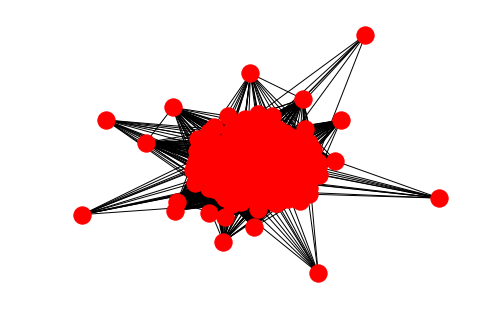

In [31]:
g = nx.from_pandas_dataframe(df_A_wo_zero_values, "nodeA", "nodeB", edge_attr=True)
nx.draw(g)
plt.show()

In [32]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 152
Number of edges: 9262
Average degree: 121.8684


Let us the most influential nodes for the spread of INF_A virus



In [33]:
#sort dictinary
import operator
def centrality_sort(centrality_dict):
    return sorted(centrality_dict.items(), key = operator.itemgetter(1))

In [53]:
deg_cen = nx.degree_centrality(g)
deg_sor = centrality_sort(deg_cen)
deg_sor[-10:] # Top 10 spread countries are the following ones with degree centrality

[('Paraguay', 0.9602649006622517),
 ('Cameroon', 0.9602649006622517),
 ('Niger', 0.9602649006622517),
 ('Guatemala', 0.9602649006622517),
 ('Finland', 0.9668874172185431),
 ('Argentina', 0.9668874172185431),
 ('Viet Nam', 0.9668874172185431),
 ('Cambodia', 0.9668874172185431),
 ('South Africa', 0.9735099337748344),
 ('Peru', 0.9735099337748344)]

The top ten coutries with high degree centrality are shown above!
Let us visualize the top 50 coutries with high degree centrality below

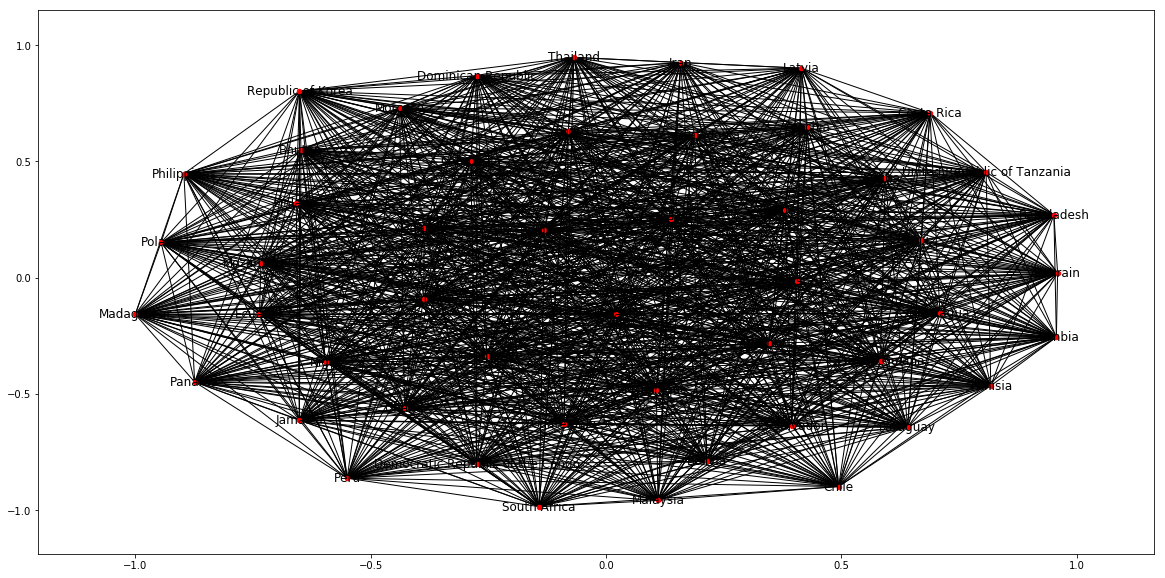

In [55]:
highest_degree = [node[0] for node in deg_sor[-50:]]
sub = g.subgraph(highest_degree)
plt.figure(figsize=(20,10))
nx.draw_networkx(sub, node_size=20, with_labels=True)

In [56]:
print(nx.info(sub))

Name: 
Type: SubGraph
Number of nodes: 50
Number of edges: 1272
Average degree:  50.8800


### Network generation for INF_B(Influenza B) type

The same way let us see the network for INF_B.

Let us first the possible combinations

In [58]:
from itertools import combinations
pairs = []
idx = 0
for e in edges_B.edge.values:
    nodes = edges_B.loc[edges_B.edge==e, "Country"].values[0]
    attrs = edges_B.loc[edges_B.edge==e, ["INF_B","START_DATE","END_DATE"]]
    combos = list(combinations(nodes, 2))
    if not len(combos):
#         pair = [e, nodes[0], None]
#         pair.extend(attrs.values[0])
#         pairs.append(pair)
        idx += 1
    else:
        for combo in combos:
            pair = [e, combo[0], combo[1]]
            pair.extend(attrs.values[0])
            pairs.append(pair)
            idx += 1
cols = ["edge","nodeA","nodeB","INF_B","START_MIN","END_MAX"]
pairs_df_B = pd.DataFrame(pairs, columns=cols)

If the number of the infulenza virus between those combination is zero, it means there is no spread between those combination.

In [59]:
df_B_wo_zero_values= pd.DataFrame(pairs_df_B.loc[pairs_df_B.INF_B > 0 ,: ] )#check if the value is greater than zero
df_B_wo_zero_values = df_B_wo_zero_values.reset_index(drop = True)# reset the index
df_B_wo_zero_values.tail()

,edge,nodeA,nodeB,INF_B,START_MIN,END_MAX
74275,12784,Germany,Ireland,155,2018-12-02,2018-02-18
74276,12843,Croatia,Germany,164,2018-01-29,2018-04-02
74277,12964,Canada,United States of America,192,2003-03-03,2003-09-03
74278,13336,Canada,Canada,323,2009-09-02,2009-03-15
74279,13540,China,United States of America,488,2016-05-23,2016-05-29


In [60]:
df_B_wo_zero_values.to_csv('INF_B.csv') # We can export this as CSV and analyize it with other software like cytoscape

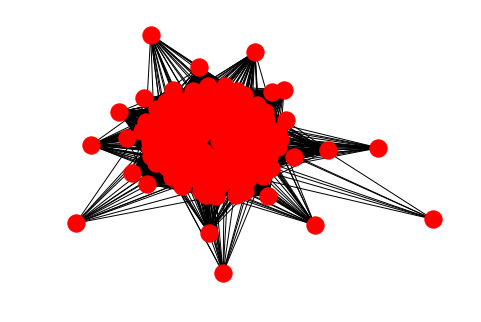

In [61]:
g_B = nx.from_pandas_dataframe(df_B_wo_zero_values, "nodeA", "nodeB", edge_attr=True)
nx.draw(g_B)
plt.show()

In [62]:
print(nx.info(g_B))

Name: 
Type: Graph
Number of nodes: 146
Number of edges: 8713
Average degree: 119.3562


In [63]:
deg_cen = nx.degree_centrality(g_B)
deg_sor = centrality_sort(deg_cen)
deg_sor[-10:] # Top 10 spread countries are the following ones with degree centrality

[('Bhutan', 0.9586206896551724),
 ('Malaysia', 0.9655172413793103),
 ('South Africa', 0.9655172413793103),
 ('Peru', 0.9655172413793103),
 ('Dominican Republic', 0.9655172413793103),
 ('Bolivia', 0.9655172413793103),
 ('Chile', 0.9724137931034482),
 ('India', 0.9724137931034482),
 ('Viet Nam', 0.9724137931034482),
 ('Costa Rica', 0.9793103448275862)]

The top ten countries with high degree centrality are shown above!
Let us visualize the top 50 countries with high degree centrality below


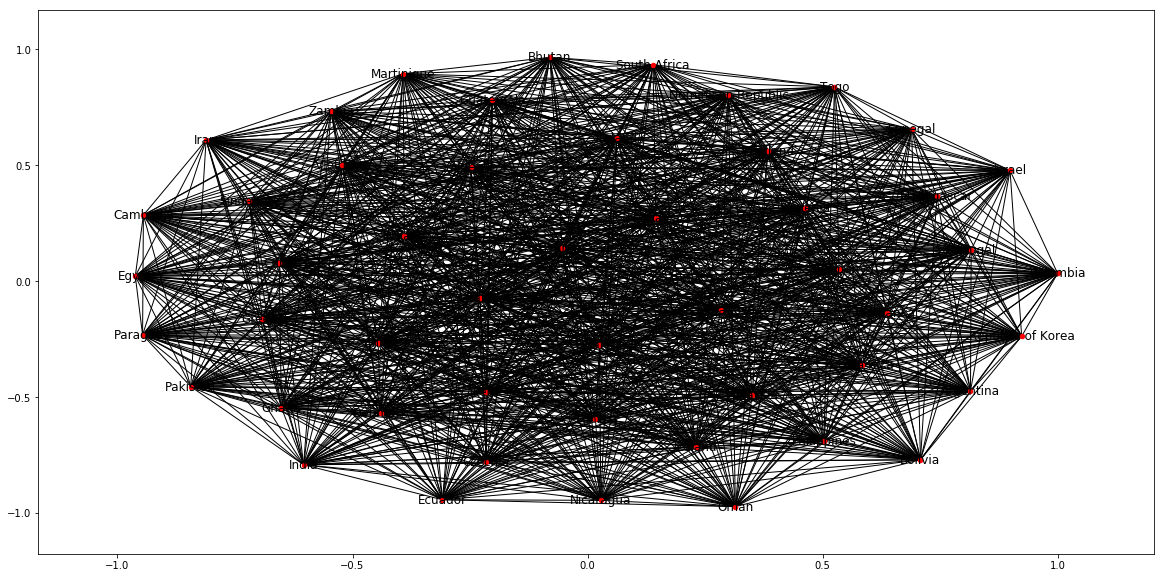

In [64]:
highest_degree = [node[0] for node in deg_sor[-50:]]
sub = g_B.subgraph(highest_degree)
plt.figure(figsize=(20,10))
nx.draw_networkx(sub, node_size=20, with_labels=True)

### predictive Model

Now we have some idea which counties with high degree centrality. Let us make some predictive model which can predict an occurrence of an influenza at certain time.

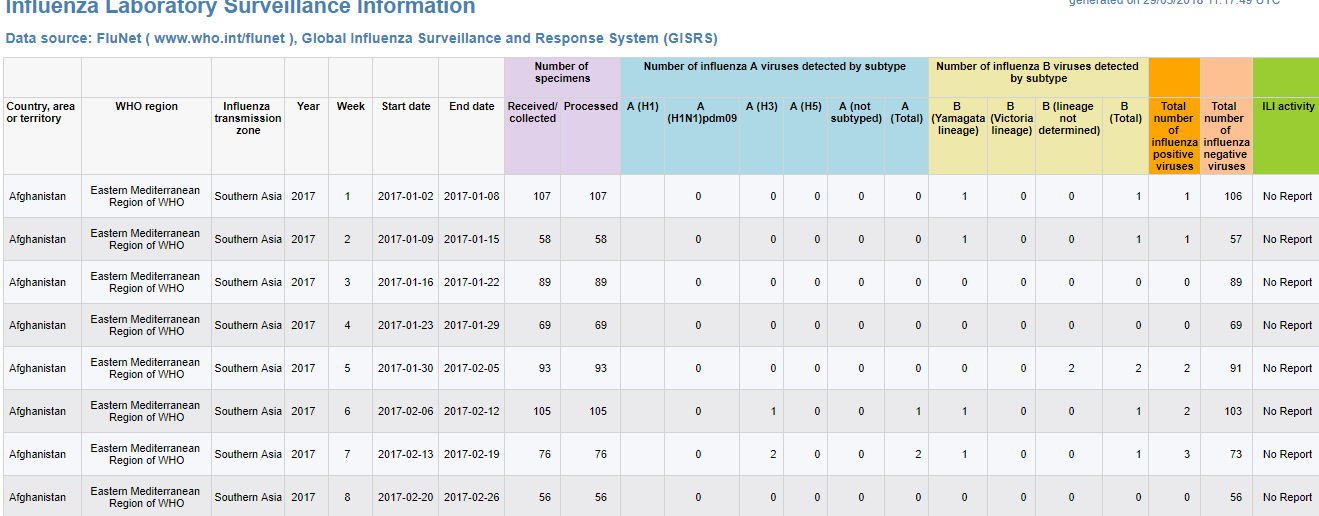

In [85]:
Image ("Capture.png",width=1000,height=1000)

In [108]:
data.ALL_INF.isnull().sum()# no missing data

0

In [109]:
data.ALL_INF2.isnull().sum() # 64987 data is missing out of  73327

64630

In [119]:
len(data)

66408

In [120]:
#Edges for inf type A
days= '7D' # Let the time stamp be 7 days 

#Here the Country are nodes and the edges are the virus spread

edges= (data.groupby(["INF_A","INF_B","ALL_INF","TITLE",
                    
                     pd.Grouper(key="SDATE", 
                                freq=days, 
                                closed="right", 
                                label="right")], 
                   as_index=False)
         .agg({"Country":','.join,
                 "SDATE":"min",
                 "EDATE":"max"})
            .reset_index()
            .rename(columns={"index":"edge",
                             "SDATE":"START_DATE", 
                             "EDATE":"END_DATE"})
           
        )
        

edges.Country = edges.Country.str.split(",")

In [121]:
from itertools import combinations
pairs = []
idx = 0
for e in edges.edge.values:
    nodes = edges.loc[edges.edge==e, "Country"].values[0]
    attrs = edges.loc[edges.edge==e, ["INF_A","INF_B","ALL_INF","TITLE","START_DATE","END_DATE"]]
    combos = list(combinations(nodes, 2))
    if not len(combos):
#         pair = [e, nodes[0], None]
#         pair.extend(attrs.values[0])
#         pairs.append(pair)
        idx += 1
    else:
        for combo in combos:
            pair = [e, combo[0], combo[1]]
            pair.extend(attrs.values[0])
            pairs.append(pair)
            idx += 1
cols = ["edge","nodeA","nodeB","INF_A","INF_B", "ALL_INF" ,"TITLE","START_MIN","END_MAX"]
pairs_df = pd.DataFrame(pairs, columns=cols)

In [122]:
pairs_df.tail()

,edge,nodeA,nodeB,INF_A,INF_B,ALL_INF,TITLE,START_MIN,END_MAX
272961,32388,Malta,Mongolia,66,0,66,No Report,2017-01-16,2017-01-22
272962,32516,Netherlands,Switzerland,68,0,68,Widespread Outbreak,2009-12-10,2009-12-20
272963,32556,Croatia,Switzerland,69,0,69,Widespread Outbreak,2009-07-12,2009-12-13
272964,34826,Israel,Sweden,167,0,167,Widespread Outbreak,2009-07-09,2009-12-13
272965,35126,Ireland,Israel,194,0,194,Widespread Outbreak,2009-09-14,2009-09-20


TITLE which is ILI report is also dominated with the No report and No Activity

In [123]:
pairs_df.TITLE.value_counts()

No Report              157948
No Activity            101728
Sporadic                12745
Local Outbreak            327
Regional Outbreak         120
Widespread Outbreak        98
Name: TITLE, dtype: int64

In [124]:
pairs_df.describe()

,edge,INF_A,INF_B,ALL_INF
count,272966.000000,272966.000000,272966.000000,272966.000000
mean,1873.332924,0.078629,0.021409,0.100038
std,1925.465322,0.823748,0.237392,0.879219
min,0.000000,0.000000,0.000000,0.000000
25%,939.000000,0.000000,0.000000,0.000000
50%,1874.000000,0.000000,0.000000,0.000000
75%,2021.000000,0.000000,0.000000,0.000000
max,35126.000000,194.000000,20.000000,194.000000


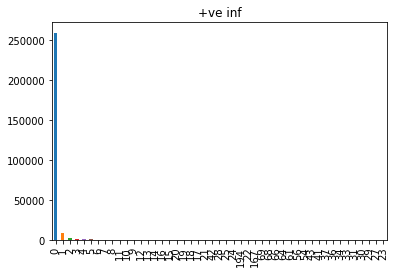

In [125]:
pairs_df.ALL_INF.value_counts().plot(kind = 'bar', title='+ve inf')

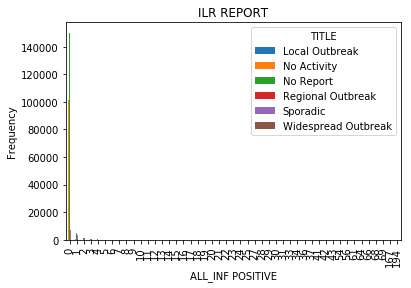

In [127]:
pd.crosstab(pairs_df.ALL_INF,pairs_df.TITLE).plot(kind='bar')
plt.title('ILR REPORT')
plt.xlabel('ALL_INF POSITIVE')
plt.ylabel('Frequency')
plt.figure(figsize=(50,20))

### ADD GEOLOCATION

At this point let us find the geo location of each countries. we can do that with the geopy API.

In [128]:
cou =(data.Country.unique())# find the unique values of Country col which gives us the 157 countries
len(cou)

156

In [129]:
col_name=["Country"]
cou_df = pd.DataFrame(cou,columns= col_name )

In [130]:
import geopy
from geopy.geocoders import Nominatim  

geolocator = Nominatim()
locs = [ geolocator.geocode(addr) for addr in cou_df.Country]
geo_info = pd.DataFrame(
    [ (addr.latitude, addr.longitude) for addr in locs ],
    columns=[ 'latitude', 'longitude'])

In [131]:
result = pd.concat([cou_df, geo_info], axis= 1)

In [132]:
result.head() # now we get the geo location info of each countries 

,Country,latitude,longitude
0,Latvia,56.840649,24.753764
1,Slovenia,45.813311,14.480837
2,Switzerland,46.798562,8.231974
3,Australia,-24.776109,134.755000
4,Cuba,23.013134,-80.832875


In [133]:
result.axes

[RangeIndex(start=0, stop=156, step=1),
 Index(['Country', 'latitude', 'longitude'], dtype='object')]

In [134]:
result.to_csv('geo_loc_info.csv') 

In [135]:
result.tail()

,Country,latitude,longitude
151,Kuwait,-12.029467,-72.860110
152,Mauritania,25.215348,55.167826
153,Myanmar,17.175050,95.999965
154,Tajikistan,38.628173,70.815654
155,Timor-Leste,-6.328484,106.955175


In [221]:
merge_cord_1 = pairs_df.merge(result, left_on='nodeA', right_on='Country')

In [222]:
merge_cord_2= merge_cord_1.merge(result, left_on='nodeB', right_on='Country')

In [223]:
merge_cord_2.tail()

,edge,nodeA,nodeB,INF_A,INF_B,ALL_INF,TITLE,START_MIN,END_MAX,Country_x,latitude_x,longitude_x,Country_y,latitude_y,longitude_y
272961,2891,Afghanistan,Afghanistan,0,0,0,Sporadic,2015-07-09,2015-12-13,Afghanistan,33.768006,66.238514,Afghanistan,33.768006,66.238514
272962,2899,Afghanistan,Afghanistan,0,0,0,Sporadic,2015-09-11,2015-11-15,Afghanistan,33.768006,66.238514,Afghanistan,33.768006,66.238514
272963,2910,Afghanistan,Afghanistan,0,0,0,Sporadic,2015-12-10,2015-12-20,Afghanistan,33.768006,66.238514,Afghanistan,33.768006,66.238514
272964,7641,Barbados,Bermuda,1,0,1,No Report,2017-01-23,2017-01-29,Barbados,13.150033,-59.525030,Bermuda,32.301822,-64.760358
272965,7641,Aruba,Bermuda,1,0,1,No Report,2017-01-23,2017-01-29,Aruba,12.501363,-69.961848,Bermuda,32.301822,-64.760358


### Calculate distance between nodeA and nodeB and we use that as one attribute factor for our prediction

In [224]:
from math import radians, sin, cos, acos, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [225]:
merge_cord_2["Distance"]=merge_cord_2.apply(lambda x: haversine(x['latitude_x'], x['longitude_x'], x['latitude_y'], x['longitude_y']), axis=1) 

In [226]:
merge_cord_2.tail()

,edge,nodeA,nodeB,INF_A,INF_B,ALL_INF,TITLE,START_MIN,END_MAX,Country_x,latitude_x,longitude_x,Country_y,latitude_y,longitude_y,Distance
272961,2891,Afghanistan,Afghanistan,0,0,0,Sporadic,2015-07-09,2015-12-13,Afghanistan,33.768006,66.238514,Afghanistan,33.768006,66.238514,0.000000
272962,2899,Afghanistan,Afghanistan,0,0,0,Sporadic,2015-09-11,2015-11-15,Afghanistan,33.768006,66.238514,Afghanistan,33.768006,66.238514,0.000000
272963,2910,Afghanistan,Afghanistan,0,0,0,Sporadic,2015-12-10,2015-12-20,Afghanistan,33.768006,66.238514,Afghanistan,33.768006,66.238514,0.000000
272964,7641,Barbados,Bermuda,1,0,1,No Report,2017-01-23,2017-01-29,Barbados,13.150033,-59.525030,Bermuda,32.301822,-64.760358,1145.510964
272965,7641,Aruba,Bermuda,1,0,1,No Report,2017-01-23,2017-01-29,Aruba,12.501363,-69.961848,Bermuda,32.301822,-64.760358,1018.052738


In [142]:
len(merge_cord_2.START_MIN.unique())

1015

In [227]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
merge_cord_2['START_MIN_ENCODED'] =lb_make.fit_transform(merge_cord_2["START_MIN"])
merge_cord_2['END_MAX_ENCODED'] =lb_make.fit_transform(merge_cord_2["END_MAX"])



In [228]:
len(merge_cord_2.START_MIN_ENCODED.unique())

1015

In [229]:
 len(merge_cord_2.END_MAX_ENCODED.unique())

1018

In [230]:
merge_cord_2.tail()

,edge,nodeA,nodeB,INF_A,INF_B,ALL_INF,TITLE,START_MIN,END_MAX,Country_x,latitude_x,longitude_x,Country_y,latitude_y,longitude_y,Distance,START_MIN_ENCODED,END_MAX_ENCODED
272961,2891,Afghanistan,Afghanistan,0,0,0,Sporadic,2015-07-09,2015-12-13,Afghanistan,33.768006,66.238514,Afghanistan,33.768006,66.238514,0.000000,936,963
272962,2899,Afghanistan,Afghanistan,0,0,0,Sporadic,2015-09-11,2015-11-15,Afghanistan,33.768006,66.238514,Afghanistan,33.768006,66.238514,0.000000,947,958
272963,2910,Afghanistan,Afghanistan,0,0,0,Sporadic,2015-12-10,2015-12-20,Afghanistan,33.768006,66.238514,Afghanistan,33.768006,66.238514,0.000000,959,964
272964,7641,Barbados,Bermuda,1,0,1,No Report,2017-01-23,2017-01-29,Barbados,13.150033,-59.525030,Bermuda,32.301822,-64.760358,1145.510964,965,970
272965,7641,Aruba,Bermuda,1,0,1,No Report,2017-01-23,2017-01-29,Aruba,12.501363,-69.961848,Bermuda,32.301822,-64.760358,1018.052738,965,970


### Now we have to chose our predictor variables and the target variable


At this point we need to define the class for our dataset. The two reasonable variables to define affected area and non-affected area were the ILI report(TITLE) and ALL_INF(negative influenzas). The problem with that is the data is skewed and most of the data tend to go to either to no report values and 0 values respectively.


In [240]:
merge_cord_2.ALL_INF.value_counts()

0      259215
1        8744
2        2571
3         997
4         513
5         271
6         182
7         127
8          67
11         49
10         42
9          35
12         31
13         23
14         22
16         14
15         11
20          8
19          5
18          4
17          3
21          3
42          2
28          2
25          2
24          2
194         1
22          1
167         1
69          1
68          1
66          1
64          1
61          1
56          1
54          1
43          1
41          1
37          1
36          1
34          1
33          1
31          1
30          1
29          1
27          1
23          1
Name: ALL_INF, dtype: int64

In [236]:
pairs_df.TITLE.value_counts() 

No Report              157948
No Activity            101728
Sporadic                12745
Local Outbreak            327
Regional Outbreak         120
Widespread Outbreak        98
Name: TITLE, dtype: int64

In [241]:
merge_cord_2.columns

Index(['edge', 'nodeA', 'nodeB', 'INF_A', 'INF_B', 'ALL_INF', 'TITLE',
       'START_MIN', 'END_MAX', 'Country_x', 'latitude_x', 'longitude_x',
       'Country_y', 'latitude_y', 'longitude_y', 'Distance',
       'START_MIN_ENCODED', 'END_MAX_ENCODED'],
      dtype='object')

In [257]:
merge_cord_2.head()

,edge,nodeA,nodeB,INF_A,INF_B,ALL_INF,TITLE,START_MIN,END_MAX,Country_x,latitude_x,longitude_x,Country_y,latitude_y,longitude_y,Distance,START_MIN_ENCODED,END_MAX_ENCODED
0,0,Norway,Poland,0,0,0,4,1996-12-30,1997-05-01,Norway,64.573154,11.528036,Poland,52.097718,19.025816,1574.510118,11,26
1,352,Norway,Poland,0,0,0,2,1998-02-11,1998-08-11,Norway,64.573154,11.528036,Poland,52.097718,19.025816,1574.510118,63,87
2,363,Norway,Poland,0,0,0,2,1998-05-10,1998-11-10,Norway,64.573154,11.528036,Poland,52.097718,19.025816,1574.510118,75,97
3,370,Norway,Poland,0,0,0,2,1998-07-09,1998-12-13,Norway,64.573154,11.528036,Poland,52.097718,19.025816,1574.510118,82,103
4,378,Norway,Poland,0,0,0,2,1998-09-11,1998-11-15,Norway,64.573154,11.528036,Poland,52.097718,19.025816,1574.510118,91,98


In [ ]:
merge_cord_2.TITLE.replace(('No Report' ,'No Activity', 'Sporadic', 'Local Outbreak','Regional Outbreak','Widespread Outbreak' ), (1, 2, 3, 4, 5,6), inplace=True)

In [216]:
merge_cord_2['ALL_INF'] = np.where(merge_cord_2['ALL_INF']>0 , 1, 0) # 1 when value is greater than 0 and 0 when value o

In [261]:
X_train = merge_cord_2.loc[:,['INF_A', 'INF_B', 'TITLE', 'START_MIN_ENCODED', 'START_MIN_ENCODED', 'Distance']]
y_train = merge_cord_2.loc[:,'ALL_INF']

In [243]:
y_train.tail()

272961    0
272962    0
272963    0
272964    1
272965    1
Name: ALL_INF, dtype: int64

### Testing data cleaning 

Testing data is taken from the year (2017 ,2018)

In [165]:
# Change the data types of SDATE and EDATE to pandas datetime data types
test.SDATE = pd.to_datetime(test.SDATE) # origin=pd.Timestamp('1995-01-01')
test.EDATE = pd.to_datetime(test.EDATE)

In [166]:
#Edges for inf type A
days= '7D' # Let the time stamp be 7 days 

#Here the Country are nodes and the edges are the virus spread

edges_t= (test.groupby(["INF_A","INF_B","ALL_INF","TITLE",
                    
                     pd.Grouper(key="SDATE", 
                                freq=days, 
                                closed="right", 
                                label="right")], 
                   as_index=False)
         .agg({"Country":','.join,
                 "SDATE":"min",
                 "EDATE":"max"})
            .reset_index()
            .rename(columns={"index":"edge",
                             "SDATE":"START_DATE", 
                             "EDATE":"END_DATE"})
           
        )
        

edges_t.Country = edges_t.Country.str.split(",")

In [167]:
from itertools import combinations
pairs = []
idx = 0
for e in edges_t.edge.values:
    nodes = edges_t.loc[edges_t.edge==e, "Country"].values[0]
    attrs = edges_t.loc[edges_t.edge==e, ["INF_A","INF_B","ALL_INF","TITLE","START_DATE","END_DATE"]]
    combos = list(combinations(nodes, 2))
    if not len(combos):
#         pair = [e, nodes[0], None]
#         pair.extend(attrs.values[0])
#         pairs.append(pair)
        idx += 1
    else:
        for combo in combos:
            pair = [e, combo[0], combo[1]]
            pair.extend(attrs.values[0])
            pairs.append(pair)
            idx += 1
cols = ["edge","nodeA","nodeB","INF_A","INF_B", "ALL_INF" ,"TITLE","START_MIN","END_MAX"]
pairs_df_t = pd.DataFrame(pairs, columns=cols)

In [168]:
pairs_df_t.tail()

,edge,nodeA,nodeB,INF_A,INF_B,ALL_INF,TITLE,START_MIN,END_MAX
30806,2580,Dominican Republic,Peru,31,9,40,No Report,2016-04-25,2016-01-05
30807,2663,Dominican Republic,Peru,38,8,46,No Report,2016-04-04,2016-10-04
30808,2706,Germany,Romania,42,0,42,No Report,2016-12-26,2017-01-01
30809,2785,Dominican Republic,Peru,51,28,79,No Report,2016-03-28,2016-03-04
30810,2888,Iran,Pakistan,66,7,73,Local Outbreak,2016-01-25,2016-01-31


calculate geolocation for the testing set

In [171]:
cou_test =(data.Country.unique())# find the unique values of Country col which gives us the 156 countries
len(cou_test)

156

In [172]:
col_name=["Country"]
cou_df_test = pd.DataFrame(cou_test,columns= col_name )

In [173]:
result_test = pd.concat([cou_df_test, geo_info], axis= 1)

In [174]:
result_test.tail()

,Country,latitude,longitude
151,Kuwait,-12.029467,-72.860110
152,Mauritania,25.215348,55.167826
153,Myanmar,17.175050,95.999965
154,Tajikistan,38.628173,70.815654
155,Timor-Leste,-6.328484,106.955175


In [244]:
merge_cord_1_t = pairs_df_t.merge(result_test, left_on='nodeA', right_on='Country')

In [245]:
merge_cord_2_t= merge_cord_1_t.merge(result_test, left_on='nodeB', right_on='Country')

In [246]:
merge_cord_2_t["Distance"]=merge_cord_2_t.apply(lambda x: haversine(x['latitude_x'], x['longitude_x'], x['latitude_y'], x['longitude_y']), axis=1) 

In [247]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
merge_cord_2_t['START_MIN_ENCODED'] =lb_make.fit_transform(merge_cord_2_t["START_MIN"])
merge_cord_2_t['END_MAX_ENCODED'] =lb_make.fit_transform(merge_cord_2_t["END_MAX"])


In [248]:
merge_cord_2_t.tail()


,edge,nodeA,nodeB,INF_A,INF_B,ALL_INF,TITLE,START_MIN,END_MAX,Country_x,latitude_x,longitude_x,Country_y,latitude_y,longitude_y,Distance,START_MIN_ENCODED,END_MAX_ENCODED
30670,1114,Kosovo,New Zealand,3,2,5,No Report,2016-03-21,2016-03-27,Kosovo,43.950881,16.209804,New Zealand,-41.500083,172.834408,10260.744889,10,12
30671,1417,Kosovo,New Zealand,5,1,6,No Report,2016-03-28,2016-03-04,Kosovo,43.950881,16.209804,New Zealand,-41.500083,172.834408,10260.744889,11,8
30672,1523,Costa Rica,New Zealand,6,0,6,No Report,2016-08-02,2016-02-14,Costa Rica,10.273563,-84.073910,New Zealand,-41.500083,172.834408,11201.902212,30,5
30673,1217,Bolivia,Chile,4,0,4,No Report,2016-02-29,2016-06-03,Bolivia,-17.056870,-64.991229,Chile,-31.761336,-71.318770,924.657966,7,21
30674,554,Bahrain,Japan,1,0,1,Sporadic,2016-07-18,2016-07-24,Bahrain,35.207801,72.547397,Japan,36.574844,139.239418,7410.710149,28,28


In [249]:
merge_cord_2_t['ALL_INF'] = np.where(merge_cord_2_t['ALL_INF']>0 , 1, 0)

In [264]:
X_test = merge_cord_2_t.loc[:,['INF_A', 'INF_B', 'TITLE', 'START_MIN_ENCODED', 'START_MIN_ENCODED', 'Distance']]
y_test = merge_cord_2_t.loc[:,'ALL_INF']

In [253]:
merge_cord_2_t.TITLE.replace(('No Report' ,'No Activity', 'Sporadic', 'Local Outbreak','Regional Outbreak','Widespread Outbreak' ), (1, 2, 3, 4, 5,6), inplace=True)

### Logistic Regression

In [262]:
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [265]:
print('Accuracy of the Logistic regression: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of the Logistic regression: 1.00


### Naive Bayes

In [266]:
from sklearn.naive_bayes import GaussianNB
model_ = GaussianNB()
model_.fit(X_train,y_train)

GaussianNB(priors=None)

In [267]:
print('Accuracy of the Naive Bayes: {:.2f}'.format(model_.score(X_test, y_test)))

Accuracy of the Naive Bayes: 0.98


With the assumption taken as class label the result is not surprising. The data is very skewed to the value 0. That gives a very biased result. The model easily learns the data by heart. As a result, a very high prediction accuracy like this happens.